##**1. PREPARACIÓN DEL ENTORNO Y ESTRUCTURA DE PROYECTO**

Este bloque monta Google Drive, importa las librerías necesarias y crea la estructura de carpetas del proyecto en el directorio del usuario.

In [ ]:
# --- Montaje de Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Importación de librerías ---
import os
import shutil
import re
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tqdm import tqdm

# --- Configuración de directorios ---
base_dir = "/content/drive/MyDrive/Colab Notebooks/bigdata/modulo3"
project_dir = os.path.join(base_dir, "proyecto_transfer")

# Subcarpetas del proyecto
data_dir = os.path.join(project_dir, "data")
models_dir = os.path.join(project_dir, "models")
results_dir = os.path.join(project_dir, "results")

# Creación de carpetas si no existen
for d in [project_dir, data_dir, models_dir, results_dir]:
    os.makedirs(d, exist_ok=True)

# Confirmación de estructura
print("Estructura de proyecto creada:")
print(f"- {data_dir}")
print(f"- {models_dir}")
print(f"- {results_dir}")


Mounted at /content/drive
Estructura de proyecto creada:
- /content/drive/MyDrive/Colab Notebooks/bigdata/modulo3/proyecto_transfer/data
- /content/drive/MyDrive/Colab Notebooks/bigdata/modulo3/proyecto_transfer/models
- /content/drive/MyDrive/Colab Notebooks/bigdata/modulo3/proyecto_transfer/results


##**2. ORGANIZACIÓN Y ETIQUETADO DEL DATASET**
Este bloque unifica las imágenes desde las subcarpetas de origen (processed/) en una sola carpeta dentro del proyecto, y genera un archivo CSV con metadatos.

In [ ]:
# --- Ruta del dataset original ---
source_dir = os.path.join(base_dir, "processed")  # Carpeta original con subcarpetas de clases
output_dir = data_dir  # Carpeta de destino dentro del proyecto

# --- Unificación de imágenes ---
for folder in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith(".png"):
            continue

        new_name = f"{folder}_{img_name}"
        src = os.path.join(folder_path, img_name)
        dst = os.path.join(output_dir, new_name)
        shutil.copy(src, dst)

print("Imágenes copiadas correctamente al directorio del proyecto.")

# --- Generación del CSV de metadatos ---
pattern = re.compile(r"([a-zA-Z]+)_([0-9]+)_([A-Za-z]+)_(\d+)\.png", re.IGNORECASE)
data = []

for file_name in os.listdir(output_dir):
    if not file_name.lower().endswith(".png"):
        continue

    match = pattern.match(file_name)
    if match:
        etiqueta = match.group(1).lower()
        codigo = match.group(2)
        objeto = match.group(3).lower()
        secuencia = int(match.group(4))
    else:
        etiqueta = file_name.split("_")[0].lower()
        codigo, objeto, secuencia = None, None, None

    data.append({
        "nombre_archivo": file_name,
        "etiqueta": etiqueta,
        "codigo_estudiante": codigo,
        "objeto": objeto,
        "secuencia": secuencia,
        "origen": "original"
    })

df = pd.DataFrame(data)
csv_path = os.path.join(output_dir, "dataset_info.csv")
df.to_csv(csv_path, index=False)

print(f"Archivo CSV generado en: {csv_path}")
print(f"Número total de imágenes registradas: {len(df)}")

# Vista previa
df.head()

Imágenes copiadas correctamente al directorio del proyecto.
Archivo CSV generado en: /content/drive/MyDrive/Colab Notebooks/bigdata/modulo3/proyecto_transfer/data/dataset_info.csv
Número total de imágenes registradas: 725


,nombre_archivo,etiqueta,codigo_estudiante,objeto,secuencia,origen
0,silla_20242595003_silla_0010.png,silla,20242595003,silla,10.0,original
1,silla_20242595003_silla_0044.png,silla,20242595003,silla,44.0,original
2,silla_20242695001_silla_011.png,silla,20242695001,silla,11.0,original
3,silla_20242691001_silla_003.png,silla,20242691001,silla,3.0,original
4,silla_20242595003_silla_0035.png,silla,20242595003,silla,35.0,original


##**3. ENTRENAMIENTO DEL AUTOENCODER CONVOLUCIONAL**

Este bloque emplea los datos sinteitcos que fueron generados mediante un procedimiento (data augmentation) aplicado durante la fase experimental del proyecto.
No se ejecuta la generación de imágenes sintéticas para evitar duplicación, pero se describe el proceso con fines de trazabilidad y documentación.

-------------------------------------------------------------------
 El proceso original utilizó el objeto ImageDataGenerator de Keras para crear versiones sintéticas de las imágenes con transformaciones geométricas y de iluminación controladas.

 Las transformaciones aplicadas fueron:
```
 - rotation_range=25            → Rotación aleatoria de hasta ±25°
 - width_shift_range=0.1        → Desplazamiento horizontal aleatorio (10%)
 - height_shift_range=0.1       → Desplazamiento vertical aleatorio (10%)
 - brightness_range=[0.7, 1.3]  → Variación de brillo entre 70% y 130%
 - zoom_range=0.2               → Zoom aleatorio hasta 20%
 - horizontal_flip=True         → Inversión horizontal aleatoria
 - fill_mode='nearest'          → Relleno de píxeles vacíos tras transformación
```
Cada imagen original generó dos imágenes sintéticas, almacenadas en la subcarpeta "synthetic/" del dataset. El archivo CSV (dataset_info.csv) fue posteriormente actualizado incluyendo los registros de las nuevas imágenes con el campo "origen" = "synthetic".

 Ejemplo (no ejecutado):

```
  datagen = ImageDataGenerator(
     rotation_range=25,
     width_shift_range=0.1,
     height_shift_range=0.1,
     brightness_range=[0.7, 1.3],
     zoom_range=0.2,
     horizontal_flip=True,
     fill_mode='nearest'
 )
```


 Este procedimiento incrementó la diversidad del dataset, reduciendo la sobreajuste (overfitting) y mejorando la capacidad de generalización del modelo.


In [ ]:
# --- Cargar CSV con metadatos ---
csv_path = os.path.join(data_dir, "dataset_info.csv")
df = pd.read_csv(csv_path)

# --- Filtrar solo las imágenes reales ---
df_original = df[df["origen"] == "original"].reset_index(drop=True)
print(f"Imágenes originales conservadas: {len(df_original)}")

# --- Guardar CSV depurado ---
filtered_csv_path = os.path.join(data_dir, "dataset_info_original.csv")
df_original.to_csv(filtered_csv_path, index=False)

# --- Limpieza opcional: si deseas usar solo reales en el entrenamiento del autoencoder ---
real_img_dir = os.path.join(data_dir, "original_only")
os.makedirs(real_img_dir, exist_ok=True)

# Copiar únicamente las imágenes reales a una nueva carpeta
for img_name in df_original["nombre_archivo"]:
    src = os.path.join(data_dir, img_name)
    dst = os.path.join(real_img_dir, img_name)
    if os.path.exists(src):
        shutil.copy(src, dst)

print(f"Carpeta creada con imágenes reales: {real_img_dir}")
print("Dataset listo para continuar el entrenamiento solo con datos originales.")

Imágenes originales conservadas: 725
Carpeta creada con imágenes reales: /content/drive/MyDrive/Colab Notebooks/bigdata/modulo3/proyecto_transfer/data/original_only
Dataset listo para continuar el entrenamiento solo con datos originales.


100%|██████████| 731/731 [00:25<00:00, 28.29it/s]


Dataset cargado correctamente. Forma: (725, 224, 224, 3)
Gráfico de arquitectura guardado en: /content/drive/MyDrive/Colab Notebooks/bigdata/modulo3/proyecto_transfer/results/autoencoder_architecture.png
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 146s 7s/step - loss: 0.0620 - val_loss: 0.0218
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 154s 8s/step - loss: 0.0224 - val_loss: 0.0095
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 189s 7s/step - loss: 0.0105 - val_loss: 0.0077
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 149s 8s/step - loss: 0.0082 - val_loss: 0.0061
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - loss: 0.0073 - val_loss: 0.0052
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 151s 8s/step - loss: 0.0063 - val_loss: 0.0045
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 197s 8s/step - loss: 0.0058 - val_loss: 0.0039
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 200s 8s/step - loss: 0.0052 - val_loss: 0.0038
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 143s 8s/step - loss: 0.0050 - val_loss: 0.0035
Epoch 10/20
19/19 ━━━━━━━━━━━━━

Modelos guardados correctamente.


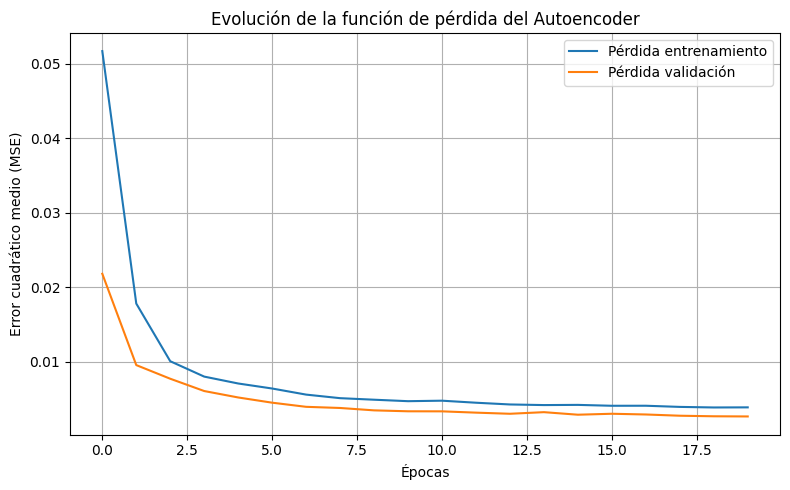

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


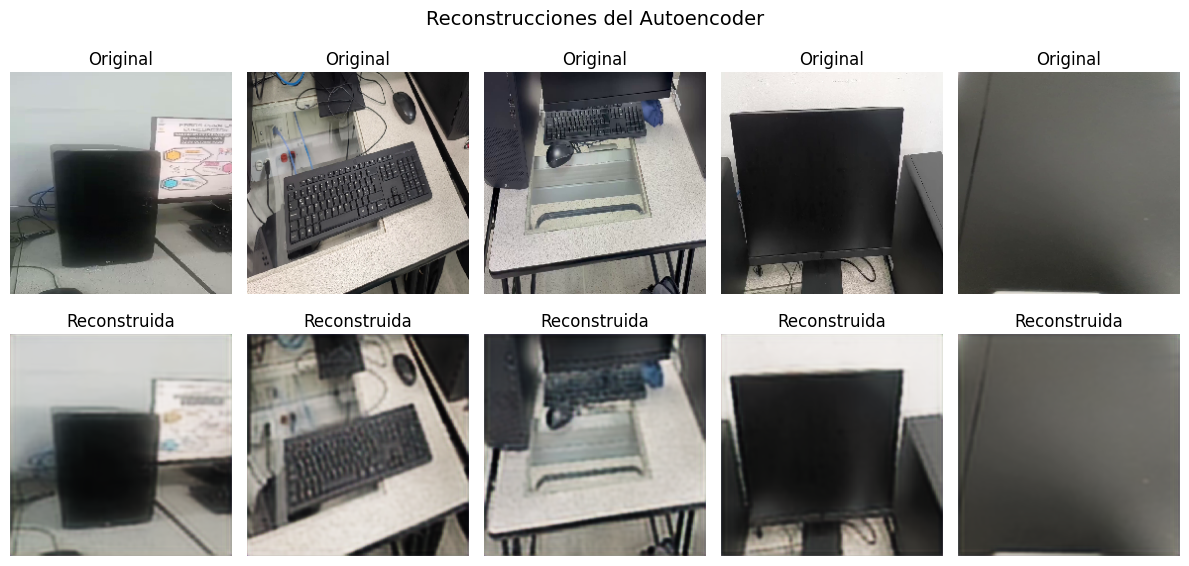

In [ ]:
# Este bloque carga todas las imágenes del dataset combinado (original + sintéticas),
# las redimensiona a 224×224×3, entrena un autoencoder convolucional y
# guarda tanto el modelo completo como el encoder.
# Además, genera un gráfico de la arquitectura de la red.

# --- Configuración de parámetros ---
img_size = (224, 224)
epochs = 20
batch_size = 32

# --- Carga de imágenes ---
images = []
for file in tqdm(os.listdir(data_dir)):
    if file.lower().endswith(".png"):
        path = os.path.join(data_dir, file)
        try:
            img = load_img(path, target_size=img_size)
            img = img_to_array(img) / 255.0
            images.append(img)
        except Exception as e:
            print(f"Error cargando {file}: {e}")

X = np.array(images)
print(f"Dataset cargado correctamente. Forma: {X.shape}")

# --- Definición del modelo Autoencoder ---
input_img = Input(shape=(224, 224, 3))

# Encoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

# Decoder
x = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# --- Visualización de la arquitectura ---
model_plot_path = os.path.join(results_dir, "autoencoder_architecture.png")
plot_model(autoencoder, to_file=model_plot_path, show_shapes=True, show_layer_names=True)
print(f"Gráfico de arquitectura guardado en: {model_plot_path}")

# --- Entrenamiento ---
history = autoencoder.fit(X, X,
                          epochs=epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_split=0.2)

# --- Guardado de modelos ---
autoencoder_path = os.path.join(models_dir, "autoencoder.h5")
encoder_path = os.path.join(models_dir, "encoder.h5")

autoencoder.save(autoencoder_path)
encoder = Model(inputs=input_img, outputs=encoded)
encoder.save(encoder_path)

print("Modelos guardados correctamente.")

# --- Visualización del entrenamiento ---
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title("Evolución de la función de pérdida del Autoencoder")
plt.xlabel("Épocas")
plt.ylabel("Error cuadrático medio (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "autoencoder_training_loss.png"))
plt.show()

# --- Visualización de reconstrucciones ---
sample_idx = np.random.choice(len(X), 5, replace=False)
decoded_imgs = autoencoder.predict(X[sample_idx])

plt.figure(figsize=(12,6))
for i in range(5):
    # Imagen original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(X[sample_idx[i]])
    plt.title("Original")
    plt.axis("off")
    # Imagen reconstruida
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstruida")
    plt.axis("off")

plt.suptitle("Reconstrucciones del Autoencoder", fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "autoencoder_reconstructions.png"))
plt.show()

##**4. EXTRACCIÓN DE FEATURES MEDIANTE EL ENCODER**

Este bloque utiliza el modelo encoder previamente entrenado para generar representaciones latentes (vectores de características)  a partir de las imágenes del dataset combinado.

In [ ]:
# --- Carga del modelo encoder ---
encoder_path = os.path.join(models_dir, "encoder.h5")
encoder = load_model(encoder_path, custom_objects={'mse': MeanSquaredError()})

# --- Carga de metadatos ---
csv_path = os.path.join(data_dir, "dataset_info.csv")
df = pd.read_csv(csv_path)

# --- Extracción de características ---
feature_list = []
valid_rows = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(data_dir, row["nombre_archivo"])
    if not os.path.exists(img_path):
        continue
    try:
        img = load_img(img_path, target_size=img_size)
        x = img_to_array(img) / 255.0
        x = np.expand_dims(x, axis=0)
        features = encoder.predict(x)
        feature_list.append(features.flatten())
        valid_rows.append(row)
    except Exception as e:
        print(f"Error procesando {row['nombre_archivo']}: {e}")

# --- Conversión a arreglo NumPy ---
features_array = np.array(feature_list)
print(f"Características extraídas: {features_array.shape}")

# --- Actualización del DataFrame con solo las imágenes válidas ---
df_valid = pd.DataFrame(valid_rows).reset_index(drop=True)

# --- Guardado de resultados ---
features_path = os.path.join(data_dir, "features.npy")
df_valid_path = os.path.join(data_dir, "dataset_info_valid.csv")

np.save(features_path, features_array)
df_valid.to_csv(df_valid_path, index=False)

print(f"Archivo de características guardado en: {features_path}")
print(f"Archivo CSV actualizado guardado en: {df_valid_path}")

  0%|          | 0/725 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


  0%|          | 1/725 [00:00<02:17,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  0%|          | 2/725 [00:00<01:55,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  0%|          | 3/725 [00:00<01:53,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  1%|          | 4/725 [00:00<01:55,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  1%|          | 5/725 [00:00<01:51,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  1%|          | 6/725 [00:00<01:49,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  1%|          | 7/725 [00:01<01:46,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  1%|          | 8/725 [00:01<01:50,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  1%|          | 9/725 [00:01<01:46,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  1%|▏         | 10/725 [00:01<01:45,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  2%|▏         | 11/725 [00:01<01:45,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  2%|▏         | 12/725 [00:01<01:42,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  2%|▏         | 13/725 [00:01<01:40,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  2%|▏         | 14/725 [00:02<01:41,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  2%|▏         | 15/725 [00:02<01:41,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  2%|▏         | 16/725 [00:02<01:40,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  2%|▏         | 17/725 [00:02<01:44,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  2%|▏         | 18/725 [00:02<01:42,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  3%|▎         | 19/725 [00:02<01:41,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  3%|▎         | 20/725 [00:02<01:40,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  3%|▎         | 21/725 [00:03<01:39,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  3%|▎         | 22/725 [00:03<01:38,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  3%|▎         | 23/725 [00:03<01:46,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  3%|▎         | 24/725 [00:03<01:44,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  3%|▎         | 25/725 [00:03<01:45,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  4%|▎         | 26/725 [00:03<01:50,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  4%|▎         | 27/725 [00:04<01:48,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  4%|▍         | 28/725 [00:04<01:48,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  4%|▍         | 29/725 [00:04<01:52,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


  4%|▍         | 30/725 [00:04<02:00,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


  4%|▍         | 31/725 [00:04<02:05,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  4%|▍         | 32/725 [00:05<02:33,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


  5%|▍         | 33/725 [00:05<02:42,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  5%|▍         | 34/725 [00:05<02:35,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  5%|▍         | 35/725 [00:05<02:43,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


  5%|▍         | 36/725 [00:06<02:44,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  5%|▌         | 37/725 [00:06<02:47,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


  5%|▌         | 38/725 [00:06<02:47,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  5%|▌         | 39/725 [00:06<02:42,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  6%|▌         | 40/725 [00:07<02:49,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  6%|▌         | 41/725 [00:07<02:58,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


  6%|▌         | 42/725 [00:07<03:01,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  6%|▌         | 43/725 [00:07<02:47,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


  6%|▌         | 44/725 [00:08<02:42,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  6%|▌         | 45/725 [00:08<02:29,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  6%|▋         | 46/725 [00:08<02:12,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  6%|▋         | 47/725 [00:08<02:00,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  7%|▋         | 48/725 [00:08<01:55,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  7%|▋         | 49/725 [00:08<01:47,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  7%|▋         | 50/725 [00:08<01:44,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  7%|▋         | 51/725 [00:09<01:49,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  7%|▋         | 52/725 [00:09<01:45,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  7%|▋         | 53/725 [00:09<01:50,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  7%|▋         | 54/725 [00:09<01:47,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  8%|▊         | 55/725 [00:09<01:42,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  8%|▊         | 56/725 [00:09<01:39,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  8%|▊         | 57/725 [00:09<01:34,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  8%|▊         | 58/725 [00:10<01:30,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  8%|▊         | 59/725 [00:10<01:30,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  8%|▊         | 60/725 [00:10<01:28,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  8%|▊         | 61/725 [00:10<01:25,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  9%|▊         | 62/725 [00:10<01:27,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  9%|▊         | 63/725 [00:10<01:23,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  9%|▉         | 64/725 [00:10<01:22,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  9%|▉         | 65/725 [00:10<01:23,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  9%|▉         | 66/725 [00:11<01:23,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  9%|▉         | 67/725 [00:11<01:26,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  9%|▉         | 68/725 [00:11<01:25,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 10%|▉         | 69/725 [00:11<01:24,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 10%|▉         | 70/725 [00:11<01:23,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 10%|▉         | 71/725 [00:11<01:22,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 10%|▉         | 72/725 [00:11<01:21,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 10%|█         | 73/725 [00:12<01:23,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 10%|█         | 74/725 [00:12<01:21,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 10%|█         | 75/725 [00:12<01:25,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 10%|█         | 76/725 [00:12<01:25,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 11%|█         | 77/725 [00:12<01:27,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 11%|█         | 78/725 [00:12<01:27,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 11%|█         | 79/725 [00:12<01:32,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 11%|█         | 80/725 [00:13<01:33,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 11%|█         | 81/725 [00:13<01:33,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 11%|█▏        | 82/725 [00:13<01:40,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 11%|█▏        | 83/725 [00:13<01:39,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 12%|█▏        | 84/725 [00:13<01:40,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 12%|█▏        | 85/725 [00:13<01:38,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 12%|█▏        | 86/725 [00:13<01:36,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 12%|█▏        | 87/725 [00:14<01:35,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 12%|█▏        | 88/725 [00:14<01:34,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 12%|█▏        | 89/725 [00:14<01:38,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 12%|█▏        | 90/725 [00:14<01:37,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 13%|█▎        | 91/725 [00:14<01:31,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 13%|█▎        | 92/725 [00:14<01:31,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 13%|█▎        | 93/725 [00:14<01:31,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 13%|█▎        | 94/725 [00:15<01:35,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 13%|█▎        | 95/725 [00:15<01:33,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 13%|█▎        | 96/725 [00:15<01:34,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 13%|█▎        | 97/725 [00:15<01:33,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 14%|█▎        | 98/725 [00:15<01:32,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 14%|█▎        | 99/725 [00:15<01:31,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 14%|█▍        | 100/725 [00:15<01:29,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 14%|█▍        | 101/725 [00:16<01:30,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 14%|█▍        | 102/725 [00:16<01:27,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 14%|█▍        | 103/725 [00:16<01:31,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 14%|█▍        | 104/725 [00:16<01:30,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 14%|█▍        | 105/725 [00:16<01:25,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 15%|█▍        | 106/725 [00:16<01:21,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 15%|█▍        | 107/725 [00:16<01:19,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 15%|█▍        | 108/725 [00:17<01:16,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 15%|█▌        | 109/725 [00:17<01:16,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 15%|█▌        | 110/725 [00:17<01:16,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 15%|█▌        | 111/725 [00:17<01:19,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 15%|█▌        | 112/725 [00:17<01:21,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 16%|█▌        | 113/725 [00:17<01:21,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 16%|█▌        | 114/725 [00:17<01:22,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 16%|█▌        | 115/725 [00:17<01:20,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 16%|█▌        | 116/725 [00:18<01:37,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 16%|█▌        | 117/725 [00:18<01:53,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 16%|█▋        | 118/725 [00:18<02:04,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 16%|█▋        | 119/725 [00:18<02:12,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 17%|█▋        | 120/725 [00:19<02:21,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 17%|█▋        | 121/725 [00:19<02:10,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 17%|█▋        | 122/725 [00:19<02:10,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 17%|█▋        | 123/725 [00:19<02:02,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 17%|█▋        | 124/725 [00:19<01:57,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 17%|█▋        | 125/725 [00:20<01:55,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 17%|█▋        | 126/725 [00:20<01:51,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 18%|█▊        | 127/725 [00:20<02:04,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 18%|█▊        | 128/725 [00:20<02:14,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 18%|█▊        | 129/725 [00:21<02:21,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 18%|█▊        | 130/725 [00:21<02:30,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 18%|█▊        | 131/725 [00:21<02:21,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 18%|█▊        | 132/725 [00:21<02:07,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 133/725 [00:21<01:52,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 18%|█▊        | 134/725 [00:22<01:42,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 19%|█▊        | 135/725 [00:22<01:36,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 19%|█▉        | 136/725 [00:22<01:31,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 19%|█▉        | 137/725 [00:22<01:31,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 19%|█▉        | 138/725 [00:22<01:28,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 19%|█▉        | 139/725 [00:22<01:30,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 19%|█▉        | 140/725 [00:22<01:28,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 19%|█▉        | 141/725 [00:23<01:33,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 20%|█▉        | 142/725 [00:23<01:29,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 20%|█▉        | 143/725 [00:23<01:26,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 20%|█▉        | 144/725 [00:23<01:25,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 20%|██        | 145/725 [00:23<01:26,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 20%|██        | 146/725 [00:23<01:28,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 20%|██        | 147/725 [00:23<01:25,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 20%|██        | 148/725 [00:24<01:23,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 21%|██        | 149/725 [00:24<01:24,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 21%|██        | 150/725 [00:24<02:56,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 21%|██        | 151/725 [00:25<02:33,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 21%|██        | 152/725 [00:25<02:10,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 21%|██        | 153/725 [00:25<01:55,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 21%|██        | 154/725 [00:25<01:44,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 21%|██▏       | 155/725 [00:25<01:36,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 22%|██▏       | 156/725 [00:25<01:38,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 22%|██▏       | 157/725 [00:25<01:33,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 22%|██▏       | 158/725 [00:26<01:30,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 22%|██▏       | 159/725 [00:26<01:26,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 22%|██▏       | 160/725 [00:26<01:29,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 22%|██▏       | 161/725 [00:26<01:25,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 22%|██▏       | 162/725 [00:26<01:24,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 22%|██▏       | 163/725 [00:26<01:25,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 23%|██▎       | 164/725 [00:27<01:23,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 23%|██▎       | 165/725 [00:27<01:24,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 23%|██▎       | 166/725 [00:27<01:23,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 23%|██▎       | 167/725 [00:27<01:21,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 23%|██▎       | 168/725 [00:27<01:21,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 23%|██▎       | 169/725 [00:27<01:19,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 23%|██▎       | 170/725 [00:27<01:22,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 24%|██▎       | 171/725 [00:28<01:20,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 24%|██▎       | 172/725 [00:28<01:23,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 24%|██▍       | 173/725 [00:28<01:21,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 24%|██▍       | 174/725 [00:28<01:21,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 24%|██▍       | 175/725 [00:28<01:24,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 24%|██▍       | 176/725 [00:28<01:21,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 24%|██▍       | 177/725 [00:29<01:29,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 25%|██▍       | 178/725 [00:29<01:29,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 25%|██▍       | 179/725 [00:29<01:29,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 25%|██▍       | 180/725 [00:29<01:25,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 25%|██▍       | 181/725 [00:29<01:27,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 25%|██▌       | 182/725 [00:29<01:24,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 25%|██▌       | 183/725 [00:29<01:21,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 25%|██▌       | 184/725 [00:30<01:22,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 26%|██▌       | 185/725 [00:30<01:24,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 26%|██▌       | 186/725 [00:30<01:23,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 26%|██▌       | 187/725 [00:30<01:23,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 26%|██▌       | 188/725 [00:30<01:20,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 26%|██▌       | 189/725 [00:30<01:16,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 26%|██▌       | 190/725 [00:30<01:13,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 26%|██▋       | 191/725 [00:31<01:14,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 26%|██▋       | 192/725 [00:31<01:12,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 27%|██▋       | 193/725 [00:31<01:10,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 27%|██▋       | 194/725 [00:31<01:09,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 27%|██▋       | 195/725 [00:31<01:25,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 27%|██▋       | 196/725 [00:31<01:39,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 27%|██▋       | 197/725 [00:32<01:49,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 27%|██▋       | 198/725 [00:32<01:45,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 27%|██▋       | 199/725 [00:32<01:53,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 28%|██▊       | 200/725 [00:32<01:58,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 28%|██▊       | 201/725 [00:33<01:52,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 28%|██▊       | 202/725 [00:33<01:59,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 28%|██▊       | 203/725 [00:33<01:51,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 28%|██▊       | 204/725 [00:33<01:46,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 28%|██▊       | 205/725 [00:33<01:53,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 28%|██▊       | 206/725 [00:34<02:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 29%|██▊       | 207/725 [00:34<02:08,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 29%|██▊       | 208/725 [00:34<02:13,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 29%|██▉       | 209/725 [00:34<02:06,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 29%|██▉       | 210/725 [00:35<02:15,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 29%|██▉       | 211/725 [00:35<02:12,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 29%|██▉       | 212/725 [00:35<02:00,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 29%|██▉       | 213/725 [00:35<01:49,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 30%|██▉       | 214/725 [00:36<01:38,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 30%|██▉       | 215/725 [00:36<01:34,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|██▉       | 216/725 [00:36<01:29,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 30%|██▉       | 217/725 [00:36<01:25,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|███       | 218/725 [00:36<01:21,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|███       | 219/725 [00:36<01:18,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 30%|███       | 220/725 [00:36<01:16,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 30%|███       | 221/725 [00:37<01:16,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 31%|███       | 222/725 [00:37<01:13,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 31%|███       | 223/725 [00:37<01:16,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 31%|███       | 224/725 [00:37<01:16,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 31%|███       | 225/725 [00:37<01:12,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 31%|███       | 226/725 [00:37<01:09,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 31%|███▏      | 227/725 [00:37<01:07,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 31%|███▏      | 228/725 [00:38<01:05,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 32%|███▏      | 229/725 [00:38<01:04,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 32%|███▏      | 230/725 [00:38<01:04,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 32%|███▏      | 231/725 [00:38<01:04,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 32%|███▏      | 232/725 [00:38<01:03,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 32%|███▏      | 233/725 [00:38<01:01,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 32%|███▏      | 234/725 [00:38<01:03,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 32%|███▏      | 235/725 [00:38<01:02,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 33%|███▎      | 236/725 [00:39<01:02,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 33%|███▎      | 237/725 [00:39<01:02,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 33%|███▎      | 238/725 [00:39<01:05,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 33%|███▎      | 239/725 [00:39<01:05,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 33%|███▎      | 240/725 [00:39<01:03,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 33%|███▎      | 241/725 [00:39<01:02,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 33%|███▎      | 242/725 [00:39<00:59,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 34%|███▎      | 243/725 [00:39<00:59,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 34%|███▎      | 244/725 [00:40<00:59,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|███▍      | 245/725 [00:40<00:59,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 34%|███▍      | 246/725 [00:40<01:01,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 34%|███▍      | 247/725 [00:40<01:02,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 34%|███▍      | 248/725 [00:40<01:01,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 34%|███▍      | 249/725 [00:40<01:01,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 34%|███▍      | 250/725 [00:40<01:01,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 35%|███▍      | 251/725 [00:41<01:02,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 35%|███▍      | 252/725 [00:41<01:02,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 35%|███▍      | 253/725 [00:41<01:02,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 35%|███▌      | 254/725 [00:41<01:02,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 35%|███▌      | 255/725 [00:41<01:05,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 35%|███▌      | 256/725 [00:41<01:03,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 35%|███▌      | 257/725 [00:41<01:02,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 36%|███▌      | 258/725 [00:41<01:05,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 36%|███▌      | 259/725 [00:42<01:04,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 36%|███▌      | 260/725 [00:42<01:03,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 36%|███▌      | 261/725 [00:42<01:02,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 36%|███▌      | 262/725 [00:42<01:03,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 36%|███▋      | 263/725 [00:42<01:01,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 36%|███▋      | 264/725 [00:42<01:00,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 37%|███▋      | 265/725 [00:42<00:58,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 37%|███▋      | 266/725 [00:42<00:57,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 37%|███▋      | 267/725 [00:43<00:57,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 37%|███▋      | 268/725 [00:43<00:56,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 37%|███▋      | 269/725 [00:43<00:55,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 37%|███▋      | 270/725 [00:43<00:56,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 37%|███▋      | 271/725 [00:43<00:57,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 38%|███▊      | 272/725 [00:43<00:57,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 38%|███▊      | 273/725 [00:43<00:59,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 38%|███▊      | 274/725 [00:44<00:57,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 38%|███▊      | 275/725 [00:44<00:57,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 38%|███▊      | 276/725 [00:44<00:56,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 38%|███▊      | 277/725 [00:44<00:56,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 38%|███▊      | 278/725 [00:44<00:56,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 38%|███▊      | 279/725 [00:44<00:58,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 39%|███▊      | 280/725 [00:44<00:58,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 39%|███▉      | 281/725 [00:44<00:57,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 39%|███▉      | 282/725 [00:45<01:03,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 39%|███▉      | 283/725 [00:45<01:07,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 39%|███▉      | 284/725 [00:45<01:21,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 39%|███▉      | 285/725 [00:45<01:27,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 39%|███▉      | 286/725 [00:46<01:33,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 40%|███▉      | 287/725 [00:46<01:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 40%|███▉      | 288/725 [00:46<01:43,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 40%|███▉      | 289/725 [00:46<01:36,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 40%|████      | 290/725 [00:46<01:34,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 40%|████      | 291/725 [00:47<01:30,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 40%|████      | 292/725 [00:47<01:35,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 40%|████      | 293/725 [00:47<01:46,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 41%|████      | 294/725 [00:47<01:49,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 41%|████      | 295/725 [00:48<01:47,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 41%|████      | 296/725 [00:48<01:55,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 41%|████      | 297/725 [00:48<01:48,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 41%|████      | 298/725 [00:48<01:37,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 41%|████      | 299/725 [00:49<01:31,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 41%|████▏     | 300/725 [00:49<01:25,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 42%|████▏     | 301/725 [00:49<01:19,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 42%|████▏     | 302/725 [00:49<01:15,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 42%|████▏     | 303/725 [00:49<01:12,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 42%|████▏     | 304/725 [00:49<01:10,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 42%|████▏     | 305/725 [00:50<01:10,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 42%|████▏     | 306/725 [00:50<01:10,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 42%|████▏     | 307/725 [00:50<01:09,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 42%|████▏     | 308/725 [00:50<01:08,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 43%|████▎     | 309/725 [00:50<01:04,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 43%|████▎     | 310/725 [00:50<01:00,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 43%|████▎     | 311/725 [00:50<00:57,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 43%|████▎     | 312/725 [00:51<00:57,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 43%|████▎     | 313/725 [00:51<00:55,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 43%|████▎     | 314/725 [00:51<00:54,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 43%|████▎     | 315/725 [00:51<00:53,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 44%|████▎     | 316/725 [00:51<00:53,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 44%|████▎     | 317/725 [00:51<00:51,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 44%|████▍     | 318/725 [00:51<00:53,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 44%|████▍     | 319/725 [00:51<00:55,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 44%|████▍     | 320/725 [00:52<00:56,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 44%|████▍     | 321/725 [00:52<00:56,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 44%|████▍     | 322/725 [00:52<00:57,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 45%|████▍     | 323/725 [00:52<00:55,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 45%|████▍     | 324/725 [00:52<00:54,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 45%|████▍     | 325/725 [00:52<00:52,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 45%|████▍     | 326/725 [00:52<00:51,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 45%|████▌     | 327/725 [00:53<00:53,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 45%|████▌     | 328/725 [00:53<00:54,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 45%|████▌     | 329/725 [00:53<00:53,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 46%|████▌     | 330/725 [00:53<00:55,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 46%|████▌     | 331/725 [00:53<00:54,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 46%|████▌     | 332/725 [00:53<00:54,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 46%|████▌     | 333/725 [00:53<00:54,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 46%|████▌     | 334/725 [00:54<00:54,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 46%|████▌     | 335/725 [00:54<00:55,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 46%|████▋     | 336/725 [00:54<00:55,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 46%|████▋     | 337/725 [00:54<00:54,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 47%|████▋     | 338/725 [00:54<00:53,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 47%|████▋     | 339/725 [00:54<00:53,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 47%|████▋     | 340/725 [00:54<00:52,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 47%|████▋     | 341/725 [00:54<00:52,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 47%|████▋     | 342/725 [00:55<00:53,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 47%|████▋     | 343/725 [00:55<00:54,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 47%|████▋     | 344/725 [00:55<00:54,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 48%|████▊     | 345/725 [00:55<00:54,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 48%|████▊     | 346/725 [00:55<00:53,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 48%|████▊     | 347/725 [00:55<01:04,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 48%|████▊     | 348/725 [00:56<01:23,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 48%|████▊     | 349/725 [00:56<01:13,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 48%|████▊     | 350/725 [00:56<01:06,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 48%|████▊     | 351/725 [00:56<01:01,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 49%|████▊     | 352/725 [00:56<00:58,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 49%|████▊     | 353/725 [00:56<00:55,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 49%|████▉     | 354/725 [00:57<00:56,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 49%|████▉     | 355/725 [00:57<00:56,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 49%|████▉     | 356/725 [00:57<00:57,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 49%|████▉     | 357/725 [00:57<00:55,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 49%|████▉     | 358/725 [00:57<00:54,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 50%|████▉     | 359/725 [00:57<00:53,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 50%|████▉     | 360/725 [00:57<00:53,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 50%|████▉     | 361/725 [00:58<00:52,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 50%|████▉     | 362/725 [00:58<00:52,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|█████     | 363/725 [00:58<00:52,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 50%|█████     | 364/725 [00:58<00:52,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 50%|█████     | 365/725 [00:58<00:57,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 50%|█████     | 366/725 [00:59<01:10,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 51%|█████     | 367/725 [00:59<01:12,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 51%|█████     | 368/725 [00:59<01:23,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 51%|█████     | 369/725 [00:59<01:28,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 51%|█████     | 370/725 [01:00<01:28,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 51%|█████     | 371/725 [01:00<01:23,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 51%|█████▏    | 372/725 [01:00<01:20,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 51%|█████▏    | 373/725 [01:00<01:23,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 52%|█████▏    | 374/725 [01:00<01:18,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 52%|█████▏    | 375/725 [01:01<01:14,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 52%|█████▏    | 376/725 [01:01<01:19,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 52%|█████▏    | 377/725 [01:01<01:19,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 52%|█████▏    | 378/725 [01:01<01:18,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 52%|█████▏    | 379/725 [01:02<01:23,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 52%|█████▏    | 380/725 [01:02<01:19,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 53%|█████▎    | 381/725 [01:02<01:09,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 53%|█████▎    | 382/725 [01:02<01:02,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 53%|█████▎    | 383/725 [01:02<00:57,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 53%|█████▎    | 384/725 [01:02<00:53,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 53%|█████▎    | 385/725 [01:03<00:50,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 53%|█████▎    | 386/725 [01:03<00:48,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 53%|█████▎    | 387/725 [01:03<00:47,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 54%|█████▎    | 388/725 [01:03<00:45,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 54%|█████▎    | 389/725 [01:03<00:44,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 54%|█████▍    | 390/725 [01:03<00:45,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 54%|█████▍    | 391/725 [01:03<00:46,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 54%|█████▍    | 392/725 [01:03<00:45,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 54%|█████▍    | 393/725 [01:04<00:45,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 54%|█████▍    | 394/725 [01:04<00:45,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 54%|█████▍    | 395/725 [01:04<00:44,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 55%|█████▍    | 396/725 [01:04<00:43,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 55%|█████▍    | 397/725 [01:04<00:42,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 55%|█████▍    | 398/725 [01:04<00:44,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 55%|█████▌    | 399/725 [01:04<00:43,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 55%|█████▌    | 400/725 [01:05<00:43,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 55%|█████▌    | 401/725 [01:05<00:42,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 55%|█████▌    | 402/725 [01:05<00:44,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 56%|█████▌    | 403/725 [01:05<00:44,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 56%|█████▌    | 404/725 [01:05<00:43,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 56%|█████▌    | 405/725 [01:05<00:43,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 56%|█████▌    | 406/725 [01:05<00:44,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 56%|█████▌    | 407/725 [01:05<00:44,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 56%|█████▋    | 408/725 [01:06<00:45,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 56%|█████▋    | 409/725 [01:06<00:44,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 57%|█████▋    | 410/725 [01:06<00:50,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 57%|█████▋    | 411/725 [01:06<00:49,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 57%|█████▋    | 412/725 [01:06<00:49,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 57%|█████▋    | 413/725 [01:06<00:47,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 57%|█████▋    | 414/725 [01:07<00:47,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 57%|█████▋    | 415/725 [01:07<00:46,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 57%|█████▋    | 416/725 [01:07<00:49,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 58%|█████▊    | 417/725 [01:07<00:47,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 58%|█████▊    | 418/725 [01:07<00:44,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 58%|█████▊    | 419/725 [01:07<00:43,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 58%|█████▊    | 420/725 [01:07<00:44,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 58%|█████▊    | 421/725 [01:08<00:43,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 58%|█████▊    | 422/725 [01:08<00:42,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 58%|█████▊    | 423/725 [01:08<00:42,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 58%|█████▊    | 424/725 [01:08<00:41,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 59%|█████▊    | 425/725 [01:08<00:40,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 59%|█████▉    | 426/725 [01:08<00:42,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 59%|█████▉    | 427/725 [01:08<00:43,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 59%|█████▉    | 428/725 [01:09<00:42,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 59%|█████▉    | 429/725 [01:09<00:42,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 59%|█████▉    | 430/725 [01:09<00:42,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 59%|█████▉    | 431/725 [01:09<00:43,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 60%|█████▉    | 432/725 [01:09<00:43,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 60%|█████▉    | 433/725 [01:09<00:42,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 60%|█████▉    | 434/725 [01:09<00:45,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 60%|██████    | 435/725 [01:10<00:44,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 60%|██████    | 436/725 [01:10<00:45,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 60%|██████    | 437/725 [01:10<00:44,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 60%|██████    | 438/725 [01:10<00:44,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 61%|██████    | 439/725 [01:10<00:44,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 61%|██████    | 440/725 [01:10<00:44,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 61%|██████    | 441/725 [01:11<00:46,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 61%|██████    | 442/725 [01:11<00:43,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 61%|██████    | 443/725 [01:11<00:44,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 61%|██████    | 444/725 [01:11<00:42,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 61%|██████▏   | 445/725 [01:11<00:40,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 62%|██████▏   | 446/725 [01:11<00:40,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 62%|██████▏   | 447/725 [01:11<00:39,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 62%|██████▏   | 448/725 [01:12<00:42,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 62%|██████▏   | 449/725 [01:12<00:40,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 62%|██████▏   | 450/725 [01:12<00:42,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 62%|██████▏   | 451/725 [01:12<00:45,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 62%|██████▏   | 452/725 [01:12<00:47,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 62%|██████▏   | 453/725 [01:13<00:50,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 63%|██████▎   | 454/725 [01:13<00:51,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 63%|██████▎   | 455/725 [01:13<00:57,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 63%|██████▎   | 456/725 [01:13<00:55,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 63%|██████▎   | 457/725 [01:13<00:54,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 63%|██████▎   | 458/725 [01:14<00:52,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 63%|██████▎   | 459/725 [01:14<00:58,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 63%|██████▎   | 460/725 [01:14<00:56,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 64%|██████▎   | 461/725 [01:14<00:54,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 64%|██████▎   | 462/725 [01:14<00:54,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 64%|██████▍   | 463/725 [01:15<00:54,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 64%|██████▍   | 464/725 [01:15<00:54,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 64%|██████▍   | 465/725 [01:15<01:00,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 64%|██████▍   | 466/725 [01:15<01:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 64%|██████▍   | 467/725 [01:16<01:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 65%|██████▍   | 468/725 [01:16<00:58,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 65%|██████▍   | 469/725 [01:16<00:50,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 65%|██████▍   | 470/725 [01:16<00:45,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 65%|██████▍   | 471/725 [01:16<00:41,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 65%|██████▌   | 472/725 [01:16<00:38,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 65%|██████▌   | 473/725 [01:17<00:37,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 65%|██████▌   | 474/725 [01:17<00:37,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 66%|██████▌   | 475/725 [01:17<00:38,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 66%|██████▌   | 476/725 [01:17<00:38,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 66%|██████▌   | 477/725 [01:17<00:38,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 66%|██████▌   | 478/725 [01:17<00:37,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 66%|██████▌   | 479/725 [01:17<00:38,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 66%|██████▌   | 480/725 [01:18<00:37,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 66%|██████▋   | 481/725 [01:18<00:37,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 66%|██████▋   | 482/725 [01:18<00:38,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 67%|██████▋   | 483/725 [01:18<00:37,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 67%|██████▋   | 484/725 [01:18<00:37,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 67%|██████▋   | 485/725 [01:18<00:36,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 67%|██████▋   | 486/725 [01:19<00:37,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 67%|██████▋   | 487/725 [01:19<00:37,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 67%|██████▋   | 488/725 [01:19<00:36,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 67%|██████▋   | 489/725 [01:19<00:36,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 68%|██████▊   | 490/725 [01:19<00:35,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 68%|██████▊   | 491/725 [01:19<00:35,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 68%|██████▊   | 492/725 [01:19<00:34,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 68%|██████▊   | 493/725 [01:20<00:34,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 68%|██████▊   | 494/725 [01:20<00:34,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 68%|██████▊   | 495/725 [01:20<00:35,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 68%|██████▊   | 496/725 [01:20<00:35,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 69%|██████▊   | 497/725 [01:20<00:34,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 69%|██████▊   | 498/725 [01:20<00:34,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 69%|██████▉   | 499/725 [01:21<00:34,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 69%|██████▉   | 500/725 [01:21<00:34,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 69%|██████▉   | 501/725 [01:21<00:35,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 69%|██████▉   | 502/725 [01:21<00:34,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 69%|██████▉   | 503/725 [01:21<00:34,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 70%|██████▉   | 504/725 [01:21<00:34,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 70%|██████▉   | 505/725 [01:21<00:34,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 70%|██████▉   | 506/725 [01:22<00:33,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 70%|██████▉   | 507/725 [01:22<00:33,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 70%|███████   | 508/725 [01:22<00:32,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 70%|███████   | 509/725 [01:22<00:33,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 70%|███████   | 510/725 [01:22<00:34,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 70%|███████   | 511/725 [01:22<00:33,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 71%|███████   | 512/725 [01:23<00:35,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 71%|███████   | 513/725 [01:23<00:36,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 71%|███████   | 514/725 [01:23<00:37,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 71%|███████   | 515/725 [01:23<00:39,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 71%|███████   | 516/725 [01:23<00:39,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 71%|███████▏  | 517/725 [01:24<00:39,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 71%|███████▏  | 518/725 [01:24<00:38,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 72%|███████▏  | 519/725 [01:24<00:35,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 72%|███████▏  | 520/725 [01:24<00:35,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 72%|███████▏  | 521/725 [01:24<00:34,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 72%|███████▏  | 522/725 [01:24<00:33,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 72%|███████▏  | 523/725 [01:25<00:33,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 72%|███████▏  | 524/725 [01:25<00:34,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 72%|███████▏  | 525/725 [01:25<00:33,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 73%|███████▎  | 526/725 [01:25<00:32,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 73%|███████▎  | 527/725 [01:25<00:31,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 73%|███████▎  | 528/725 [01:25<00:32,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 73%|███████▎  | 529/725 [01:25<00:31,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 73%|███████▎  | 530/725 [01:26<00:30,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 73%|███████▎  | 531/725 [01:26<00:40,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 73%|███████▎  | 532/725 [01:26<00:39,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 74%|███████▎  | 533/725 [01:26<00:40,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 74%|███████▎  | 534/725 [01:27<00:45,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 74%|███████▍  | 535/725 [01:27<00:47,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 74%|███████▍  | 536/725 [01:27<00:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 74%|███████▍  | 537/725 [01:28<00:49,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 74%|███████▍  | 538/725 [01:28<00:50,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 74%|███████▍  | 539/725 [01:28<00:47,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 74%|███████▍  | 540/725 [01:28<00:44,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 75%|███████▍  | 541/725 [01:29<00:44,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 75%|███████▍  | 542/725 [01:29<00:45,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 75%|███████▍  | 543/725 [01:29<00:43,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 75%|███████▌  | 544/725 [01:29<00:45,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 75%|███████▌  | 545/725 [01:30<00:45,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 75%|███████▌  | 546/725 [01:30<00:42,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 75%|███████▌  | 547/725 [01:30<00:38,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 76%|███████▌  | 548/725 [01:30<00:34,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 76%|███████▌  | 549/725 [01:30<00:32,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 76%|███████▌  | 550/725 [01:30<00:30,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 76%|███████▌  | 551/725 [01:30<00:29,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 76%|███████▌  | 552/725 [01:31<00:28,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 76%|███████▋  | 553/725 [01:31<00:28,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 76%|███████▋  | 554/725 [01:31<00:29,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 77%|███████▋  | 555/725 [01:31<00:28,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 77%|███████▋  | 556/725 [01:31<00:26,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 77%|███████▋  | 557/725 [01:31<00:26,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 77%|███████▋  | 558/725 [01:32<00:25,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 77%|███████▋  | 559/725 [01:32<00:27,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 77%|███████▋  | 560/725 [01:32<00:26,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 77%|███████▋  | 561/725 [01:32<00:25,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 78%|███████▊  | 562/725 [01:32<00:24,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 78%|███████▊  | 563/725 [01:32<00:23,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 78%|███████▊  | 564/725 [01:32<00:23,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 78%|███████▊  | 565/725 [01:33<00:22,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 78%|███████▊  | 566/725 [01:33<00:23,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 78%|███████▊  | 567/725 [01:33<00:22,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 78%|███████▊  | 568/725 [01:33<00:22,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 78%|███████▊  | 569/725 [01:33<00:21,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 79%|███████▊  | 570/725 [01:33<00:21,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 79%|███████▉  | 571/725 [01:33<00:21,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 79%|███████▉  | 572/725 [01:34<00:21,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 79%|███████▉  | 573/725 [01:34<00:22,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 79%|███████▉  | 574/725 [01:34<00:21,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 79%|███████▉  | 575/725 [01:34<00:21,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 79%|███████▉  | 576/725 [01:34<00:22,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 80%|███████▉  | 577/725 [01:34<00:21,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 80%|███████▉  | 578/725 [01:35<00:22,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 80%|███████▉  | 579/725 [01:35<00:22,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 80%|████████  | 580/725 [01:35<00:22,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 80%|████████  | 581/725 [01:35<00:22,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 80%|████████  | 582/725 [01:35<00:22,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 80%|████████  | 583/725 [01:35<00:22,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 81%|████████  | 584/725 [01:35<00:22,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 81%|████████  | 585/725 [01:36<00:22,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 81%|████████  | 586/725 [01:36<00:21,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 81%|████████  | 587/725 [01:36<00:22,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 81%|████████  | 588/725 [01:36<00:22,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 81%|████████  | 589/725 [01:36<00:21,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 81%|████████▏ | 590/725 [01:36<00:21,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 82%|████████▏ | 591/725 [01:37<00:21,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 82%|████████▏ | 592/725 [01:37<00:20,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 82%|████████▏ | 593/725 [01:37<00:21,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 82%|████████▏ | 594/725 [01:37<00:21,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 82%|████████▏ | 595/725 [01:37<00:20,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████▏ | 596/725 [01:37<00:20,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 82%|████████▏ | 597/725 [01:38<00:20,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 82%|████████▏ | 598/725 [01:38<00:19,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 83%|████████▎ | 599/725 [01:38<00:19,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 83%|████████▎ | 600/725 [01:38<00:20,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 83%|████████▎ | 601/725 [01:38<00:18,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 83%|████████▎ | 602/725 [01:38<00:17,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 83%|████████▎ | 603/725 [01:38<00:17,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 83%|████████▎ | 604/725 [01:39<00:16,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 83%|████████▎ | 605/725 [01:39<00:16,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 84%|████████▎ | 606/725 [01:39<00:16,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 84%|████████▎ | 607/725 [01:39<00:17,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 84%|████████▍ | 608/725 [01:39<00:16,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 84%|████████▍ | 609/725 [01:39<00:16,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 84%|████████▍ | 610/725 [01:39<00:16,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 84%|████████▍ | 611/725 [01:40<00:16,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 84%|████████▍ | 612/725 [01:40<00:16,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 85%|████████▍ | 613/725 [01:40<00:18,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 85%|████████▍ | 614/725 [01:40<00:22,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 85%|████████▍ | 615/725 [01:40<00:21,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 85%|████████▍ | 616/725 [01:41<00:23,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 85%|████████▌ | 617/725 [01:41<00:24,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 85%|████████▌ | 618/725 [01:41<00:24,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 85%|████████▌ | 619/725 [01:41<00:23,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 86%|████████▌ | 620/725 [01:42<00:22,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 86%|████████▌ | 621/725 [01:42<00:24,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 86%|████████▌ | 622/725 [01:42<00:23,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 86%|████████▌ | 623/725 [01:42<00:23,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 86%|████████▌ | 624/725 [01:42<00:22,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 86%|████████▌ | 625/725 [01:43<00:21,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 86%|████████▋ | 626/725 [01:43<00:23,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 86%|████████▋ | 627/725 [01:43<00:23,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 87%|████████▋ | 628/725 [01:43<00:22,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 87%|████████▋ | 629/725 [01:44<00:20,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 87%|████████▋ | 630/725 [01:44<00:19,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 87%|████████▋ | 631/725 [01:44<00:18,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 87%|████████▋ | 632/725 [01:44<00:17,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 87%|████████▋ | 633/725 [01:44<00:17,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 87%|████████▋ | 634/725 [01:45<00:17,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 88%|████████▊ | 635/725 [01:45<00:16,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 88%|████████▊ | 636/725 [01:45<00:16,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 88%|████████▊ | 637/725 [01:45<00:14,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 88%|████████▊ | 638/725 [01:45<00:13,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 88%|████████▊ | 639/725 [01:45<00:13,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 88%|████████▊ | 640/725 [01:45<00:12,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 88%|████████▊ | 641/725 [01:46<00:12,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 89%|████████▊ | 642/725 [01:46<00:12,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 89%|████████▊ | 643/725 [01:46<00:11,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 89%|████████▉ | 644/725 [01:46<00:11,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 89%|████████▉ | 645/725 [01:46<00:11,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 89%|████████▉ | 646/725 [01:46<00:11,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 89%|████████▉ | 647/725 [01:46<00:11,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 89%|████████▉ | 648/725 [01:47<00:11,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 90%|████████▉ | 649/725 [01:47<00:10,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 90%|████████▉ | 650/725 [01:47<00:10,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 90%|████████▉ | 651/725 [01:47<00:10,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 90%|████████▉ | 652/725 [01:47<00:10,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 90%|█████████ | 653/725 [01:47<00:09,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 90%|█████████ | 654/725 [01:47<00:10,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 90%|█████████ | 655/725 [01:48<00:10,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 90%|█████████ | 656/725 [01:48<00:10,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 91%|█████████ | 657/725 [01:48<00:10,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 91%|█████████ | 658/725 [01:48<00:10,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 91%|█████████ | 659/725 [01:48<00:09,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 91%|█████████ | 660/725 [01:48<00:09,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 91%|█████████ | 661/725 [01:48<00:09,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 91%|█████████▏| 662/725 [01:49<00:09,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 91%|█████████▏| 663/725 [01:49<00:09,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 92%|█████████▏| 664/725 [01:49<00:09,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 92%|█████████▏| 665/725 [01:49<00:09,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 92%|█████████▏| 666/725 [01:49<00:09,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 92%|█████████▏| 667/725 [01:49<00:08,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 92%|█████████▏| 668/725 [01:50<00:09,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 92%|█████████▏| 669/725 [01:50<00:09,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 92%|█████████▏| 670/725 [01:50<00:08,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 93%|█████████▎| 671/725 [01:50<00:08,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 93%|█████████▎| 672/725 [01:50<00:08,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 93%|█████████▎| 673/725 [01:50<00:07,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 93%|█████████▎| 674/725 [01:50<00:07,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 93%|█████████▎| 675/725 [01:51<00:07,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 93%|█████████▎| 676/725 [01:51<00:07,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 93%|█████████▎| 677/725 [01:51<00:07,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 94%|█████████▎| 678/725 [01:51<00:07,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 94%|█████████▎| 679/725 [01:51<00:07,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 94%|█████████▍| 680/725 [01:51<00:06,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 94%|█████████▍| 681/725 [01:52<00:06,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 94%|█████████▍| 682/725 [01:52<00:06,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 94%|█████████▍| 683/725 [01:52<00:06,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 94%|█████████▍| 684/725 [01:52<00:06,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████▍| 685/725 [01:52<00:06,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 95%|█████████▍| 686/725 [01:52<00:06,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 95%|█████████▍| 687/725 [01:53<00:05,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|█████████▍| 688/725 [01:53<00:05,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 95%|█████████▌| 689/725 [01:53<00:05,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 95%|█████████▌| 690/725 [01:53<00:05,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 95%|█████████▌| 691/725 [01:53<00:05,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 95%|█████████▌| 692/725 [01:53<00:05,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 96%|█████████▌| 693/725 [01:54<00:06,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 96%|█████████▌| 694/725 [01:54<00:06,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 96%|█████████▌| 695/725 [01:54<00:07,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 96%|█████████▌| 696/725 [01:54<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 96%|█████████▌| 697/725 [01:55<00:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 96%|█████████▋| 698/725 [01:55<00:06,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 96%|█████████▋| 699/725 [01:55<00:05,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 97%|█████████▋| 700/725 [01:55<00:05,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 97%|█████████▋| 701/725 [01:56<00:05,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 97%|█████████▋| 702/725 [01:56<00:05,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████▋| 703/725 [01:56<00:05,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 97%|█████████▋| 704/725 [01:56<00:04,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 97%|█████████▋| 705/725 [01:56<00:04,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 97%|█████████▋| 706/725 [01:57<00:04,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 98%|█████████▊| 707/725 [01:57<00:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 98%|█████████▊| 708/725 [01:57<00:04,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 98%|█████████▊| 709/725 [01:57<00:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 98%|█████████▊| 710/725 [01:58<00:03,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 98%|█████████▊| 711/725 [01:58<00:02,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 98%|█████████▊| 712/725 [01:58<00:02,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 98%|█████████▊| 713/725 [01:58<00:01,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 98%|█████████▊| 714/725 [01:58<00:01,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 99%|█████████▊| 715/725 [01:58<00:01,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 99%|█████████▉| 716/725 [01:58<00:01,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 99%|█████████▉| 717/725 [01:59<00:01,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 99%|█████████▉| 718/725 [01:59<00:01,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 99%|█████████▉| 719/725 [01:59<00:00,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 99%|█████████▉| 720/725 [01:59<00:00,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 99%|█████████▉| 721/725 [01:59<00:00,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


100%|█████████▉| 722/725 [01:59<00:00,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


100%|█████████▉| 723/725 [01:59<00:00,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


100%|█████████▉| 724/725 [02:00<00:00,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


100%|██████████| 725/725 [02:00<00:00,  6.03it/s]


Características extraídas: (725, 200704)
Archivo de características guardado en: /content/drive/MyDrive/Colab Notebooks/bigdata/modulo3/proyecto_transfer/data/features.npy
Archivo CSV actualizado guardado en: /content/drive/MyDrive/Colab Notebooks/bigdata/modulo3/proyecto_transfer/data/dataset_info_valid.csv


##**5. CLASIFICACIÓN SUPERVISADA (TRANSFER LEARNING INTERNO)**

Este bloque entrena un clasificador denso a partir de las características extraídas por el encoder (sin reentrenar el encoder).
Se aplica una división 80/20 para entrenamiento y validación.


Tamaño de entrenamiento: 580 muestras
Tamaño de validación: 145 muestras


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.2045 - loss: 17.0565 - val_accuracy: 0.3931 - val_loss: 3.2193
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.4025 - loss: 4.9020 - val_accuracy: 0.6414 - val_loss: 1.2042
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4844 - loss: 2.0364 - val_accuracy: 0.7448 - val_loss: 0.9081
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6013 - loss: 1.1104 - val_accuracy: 0.8414 - val_loss: 0.7714
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6300 - loss: 1.0733 - val_accuracy: 0.8483 - val_loss: 0.6982
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7737 - loss: 0.7389 - val_accuracy: 0.8621 - val_loss: 0.6641
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7894 - loss: 0.6633 - val_accuracy: 0.8552 - val_loss: 0.6325
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7972 - loss: 0.5672 - val_accuracy: 0.8552 - val_loss

Clasificador y etiquetas guardados correctamente.


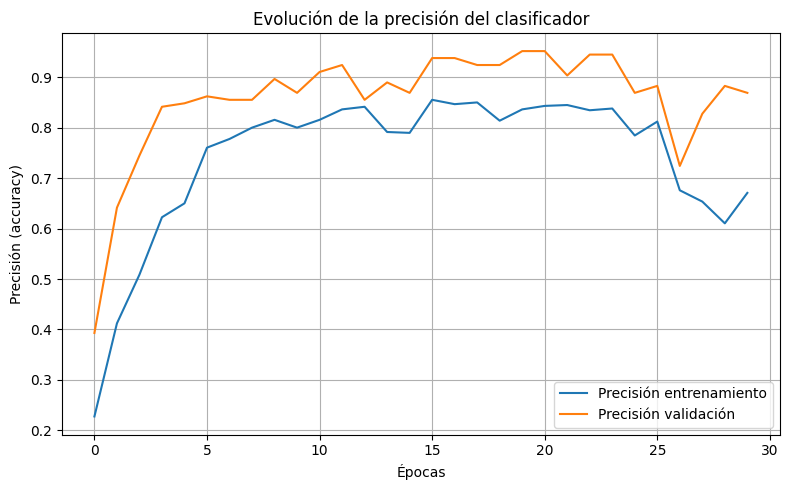

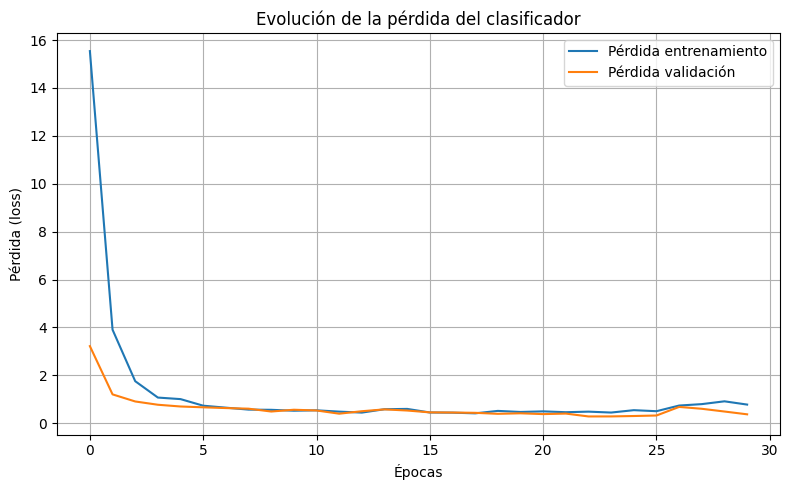

In [ ]:
# --- Carga de datos ---
features_path = os.path.join(data_dir, "features.npy")
df_valid_path = os.path.join(data_dir, "dataset_info_valid.csv")

X = np.load(features_path)
df_valid = pd.read_csv(df_valid_path)

# --- Codificación de etiquetas ---
y = df_valid["etiqueta"].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

# --- División entrenamiento / validación ---
X_train, X_val, y_train, y_val, train_idx, val_idx = train_test_split(
    X, y_encoded, df_valid.index,
    test_size=0.2, random_state=42, stratify=y_encoded
)
df_val = df_valid.loc[val_idx].reset_index(drop=True)
df_val.to_csv(os.path.join(data_dir, "dataset_val_split.csv"), index=False)

print(f"Tamaño de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño de validación: {X_val.shape[0]} muestras")

# --- Definición del clasificador ---
classifier = Sequential([
    Dense(512, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

classifier.compile(optimizer=Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# --- Entrenamiento del clasificador ---
history = classifier.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# --- Guardado de modelos ---
classifier_path = os.path.join(models_dir, "cnn_classifier.h5")
labels_path = os.path.join(models_dir, "label_encoder.npy")

classifier.save(classifier_path)
np.save(labels_path, le.classes_)

print("Clasificador y etiquetas guardados correctamente.")

# --- Visualización de curvas de entrenamiento ---
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.title("Evolución de la precisión del clasificador")
plt.xlabel("Épocas")
plt.ylabel("Precisión (accuracy)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "classifier_training_accuracy.png"))
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title("Evolución de la pérdida del clasificador")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (loss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "classifier_training_loss.png"))
plt.show()

##**6. EVALUACIÓN Y MÉTRICAS FINALES**
Este bloque evalúa el rendimiento del clasificador entrenado utilizando métricas de precisión, recall, F1-score y la matriz de confusión.

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
Resultados del clasificador:
Accuracy: 0.8690
Precision (ponderada): 0.8816
Recall (ponderado): 0.8690
F1-score (ponderado): 0.8691

Reporte de clasificación por clase:

              precision    recall  f1-score   support

         cpu       0.77      0.89      0.83        19
        mesa       0.96      0.92      0.94        24
       mouse       0.90      0.82      0.86        22
        nada       1.00      0.90      0.95        10
    pantalla       0.86      0.86      0.86        22
       silla       0.95      0.73      0.83        26
     teclado       0.76      1.00      0.86        22

    accuracy                           0.87       145
   macro avg       0.89      0.87      0.87       145
weighted avg       0.88      0.87      0.87       145



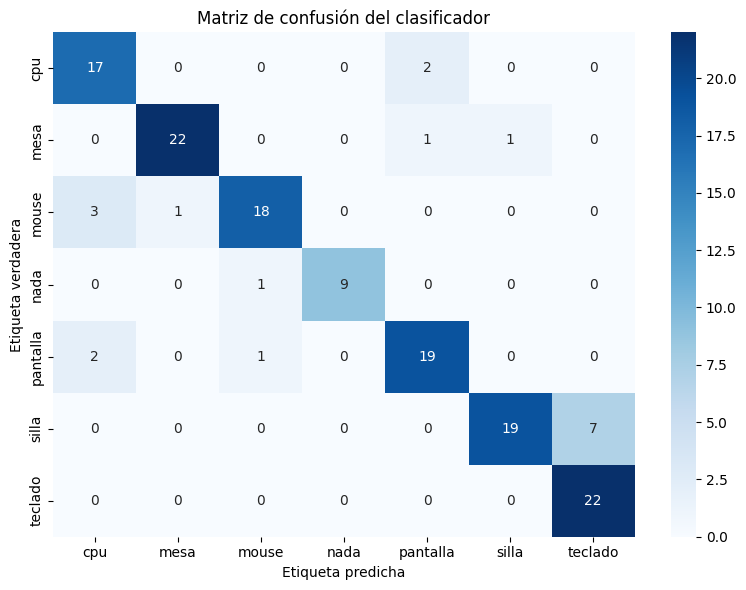

In [ ]:
# --- Predicciones sobre el conjunto de validación ---
y_pred_prob = classifier.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

# --- Cálculo de métricas ---
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)

print("Resultados del clasificador:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision (ponderada): {prec:.4f}")
print(f"Recall (ponderado): {rec:.4f}")
print(f"F1-score (ponderado): {f1:.4f}\n")

# --- Reporte detallado por clase ---
report = classification_report(y_val, y_pred, target_names=le.classes_)
print("Reporte de clasificación por clase:\n")
print(report)

# --- Matriz de confusión ---
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de confusión del clasificador")
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta verdadera")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "classifier_confusion_matrix.png"))
plt.show()

##**7. VISUALIZACIÓN DE PREDICCIONES CORRECTAS E INCORRECTAS**
Este bloque muestra ejemplos visuales de predicciones del clasificador, comparando las etiquetas verdaderas y predichas. Permite observar los aciertos y errores más representativos.

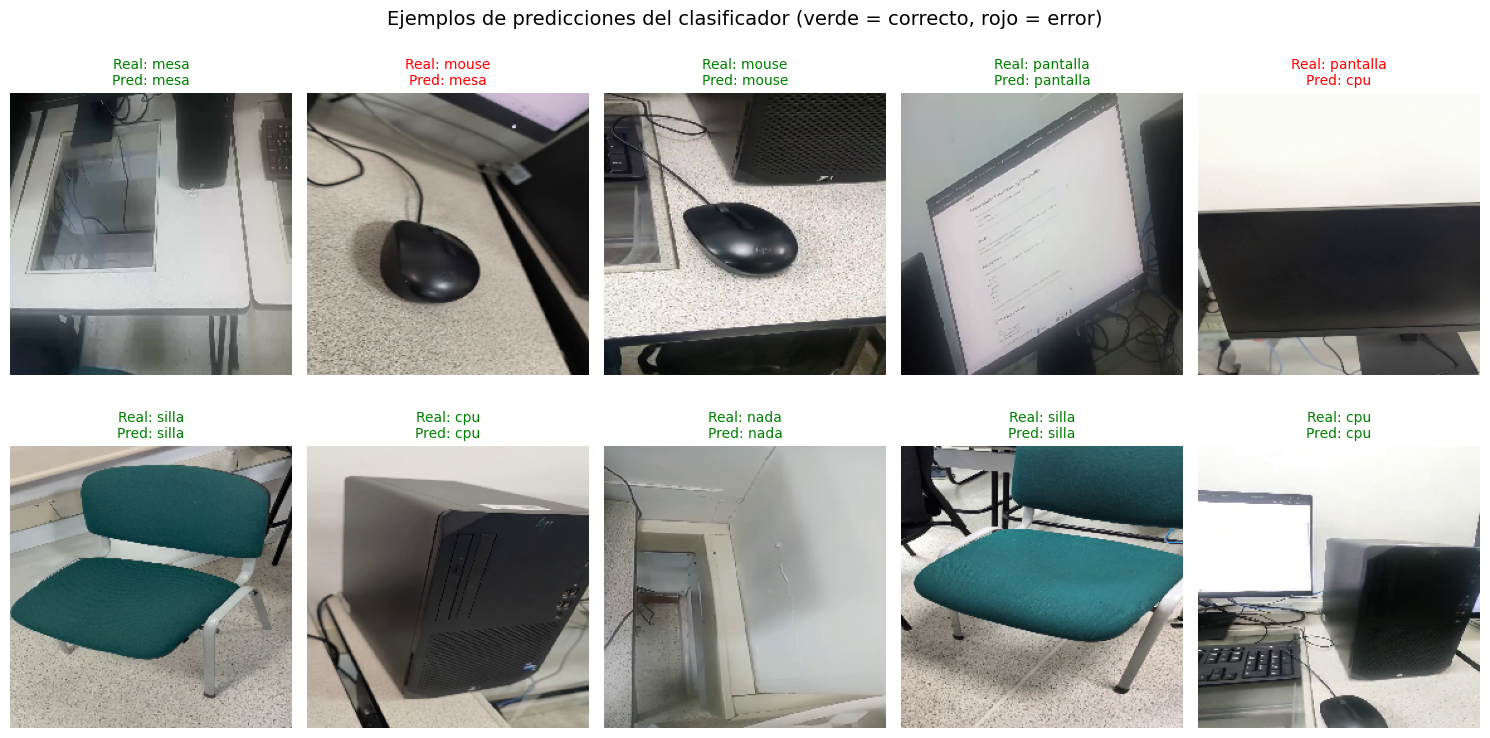

In [ ]:
# Cargar el CSV de validación exacto
df_val = pd.read_csv(os.path.join(data_dir, "dataset_val_split.csv"))

# Selección aleatoria de ejemplos del conjunto de validación
num_samples = 10
sample_indices = np.random.choice(len(df_val), num_samples, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(sample_indices):
    img_name = df_val.iloc[idx]["nombre_archivo"]
    img_path = os.path.join(data_dir, img_name)
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0

    true_label = le.inverse_transform([y_val[idx]])[0]
    pred_label = le.inverse_transform([y_pred[idx]])[0]
    correct = (true_label == pred_label)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img_array)
    plt.title(f"Real: {true_label}\nPred: {pred_label}",
              color="green" if correct else "red", fontsize=10)
    plt.axis("off")

plt.suptitle("Ejemplos de predicciones del clasificador (verde = correcto, rojo = error)", fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "classifier_predictions_examples.png"))
plt.show()